In [2]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import warnings
from PIL import Image, ImageDraw, ImageFont
from scipy.stats import pearsonr, chi2_contingency, chisquare
from statsmodels.stats.contingency_tables import mcnemar

warnings.filterwarnings('ignore')

# Считывание и предобработка данных

## Базовая обработка

In [3]:
df = pd.read_csv('../Health_cleaned_income_delta.csv')

In [3]:
df.head()

,hhidpn,rmstat,ragender,rahispan,raracem,riwbegy,ragey_b,sagey_b,rhltc,rhlthlm,...,siearn_delta,ripena_delta,sipena_delta,rgov_delta,sgov_delta,total_work_income_delta,total_pension_income_delta,total_gov_income_delta,total_income_delta,broken
0,22861040,1,2,0,2,1992-04-01,62,56,5,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,25154020,1,2,0,2,1992-04-01,56,59,3,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2,25181010,1,2,0,1,1992-04-06,58,53,3,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,11067020,1,2,0,1,1992-04-07,53,50,3,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,22861010,1,1,0,2,1992-04-07,56,62,3,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [4]:
df.columns

Index(['hhidpn', 'rmstat', 'ragender', 'rahispan', 'raracem', 'riwbegy',
       'ragey_b', 'sagey_b', 'rhltc', 'rhlthlm', 'rhibpe', 'rdiabe', 'rcancre',
       'rlunge', 'rhearte', 'rstroke', 'rpsyche', 'rarthre', 'rhosp',
       'rhspnit', 'oop_spend', 'riearn', 'ripena', 'siearn', 'sipena', 'rcovr',
       'rcovs', 'rlbrf', 'rjphys', 'rjlift', 'rjweeks', 'rjweek2', 'rjcten',
       'index_wave', 'insured_gov', 'uninsured', 'retired', 'collegeplus',
       'year', 'cpi', 'rgov', 'sgov', 'inter_year', 'year_of_birth',
       'total_work_income', 'total_pension_income', 'total_gov_income',
       'total_income', 'without_work', 'n_jobs', 'riearn_delta',
       'siearn_delta', 'ripena_delta', 'sipena_delta', 'rgov_delta',
       'sgov_delta', 'total_work_income_delta', 'total_pension_income_delta',
       'total_gov_income_delta', 'total_income_delta', 'broken'],
      dtype='object')

In [5]:
df['rhltc'].value_counts()

3     101577
4      33612
.m     15862
2      12860
5       3753
1       3097
Name: rhltc, dtype: int64

In [6]:
def reformat_rhltc(el):
    if el == '.m':
        return el
    return 3 - int(el)

def return_group(el):
    if el == '.m':
        return '.m'
    if el == 1 or el == 3:
        return 'super'
    if el == 4 or el == 6:
        return 'hard'
    if el == 2 or el == 7:
        return 'dead'
    if el == 8:
        return 'gigachad'
    if el == 5:
        return 'kill women'


def return_age_group(el):
    age = 1992 - el
    if age < 45:
        return 'young'
    elif 45 <= age <= 65:
        return 'middle'
    elif 65 <= age <= 80:
        return 'old'
    else:
        return 'dead outside'

df['rhltc'] = df['rhltc'].apply(reformat_rhltc)
df['mariage_group'] = df['rmstat'].apply(return_group)
df['age_group'] = df['year_of_birth'].apply(return_age_group)
df.head()

,hhidpn,rmstat,ragender,rahispan,raracem,riwbegy,ragey_b,sagey_b,rhltc,rhlthlm,...,sipena_delta,rgov_delta,sgov_delta,total_work_income_delta,total_pension_income_delta,total_gov_income_delta,total_income_delta,broken,mariage_group,age_group
0,22861040,1,2,0,2,1992-04-01,62,56,-2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,super,middle
1,25154020,1,2,0,2,1992-04-01,56,59,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,super,middle
2,25181010,1,2,0,1,1992-04-06,58,53,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,super,middle
3,11067020,1,2,0,1,1992-04-07,53,50,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,super,middle
4,22861010,1,1,0,2,1992-04-07,56,62,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,super,middle


In [15]:
df['broken'] = df['broken'].map({False: 0, True: 1})

## Создание датафрейма с "группами брака"

In [7]:
rmstat_df = df[(df['rmstat'] != '.m') & (df['rhltc'] != '.m')]

In [8]:
rmstat_df.shape

(154799, 63)

In [9]:
rmstat_df['rmstat'] = rmstat_df['rmstat'].astype(int)
rmstat_df['rmstat'].value_counts().sort_index()

1    97981
2     1121
3     4483
4     2430
5    13697
6     1057
7    29037
8     4993
Name: rmstat, dtype: int64

In [10]:
amount_of_statuses = rmstat_df.groupby('hhidpn')['rmstat'].nunique()
amount_of_statuses.value_counts()

1    23104
2     5392
3     1190
4      217
5       34
6        2
Name: rmstat, dtype: int64

In [11]:
single = rmstat_df[rmstat_df['hhidpn'].isin(amount_of_statuses[amount_of_statuses == 1].index)]
single.shape

(103721, 63)

In [12]:
rmstat_df['mariage_group'].value_counts().reindex(['super', 'hard', 'dead', 'gigachad', 'kill women'])

super         17121
hard            593
dead           2033
gigachad        853
kill women     2277
Name: mariage_group, dtype: int64

In [13]:
rmstat_df['age_group'].value_counts().reindex(['young', 'middle', 'old', 'dead outside'])

young            22369
middle          106051
old              24657
dead outside      1722
Name: age_group, dtype: int64

# Графики

In [15]:
sns.set()

## Графики, связанные с доходом

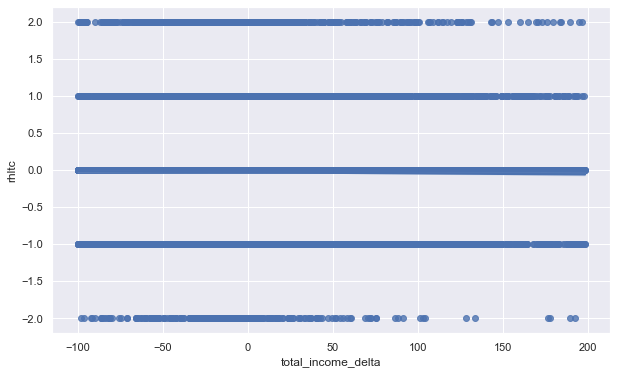

In [16]:
# make line plot of rhltc over total_income

income_health_df = df[(df['rhltc'] != '.m') & (df['n_jobs'] == 1)]
income_health_df['rhltc'] = income_health_df['rhltc'].astype(int)
income_health_df = income_health_df.dropna(subset=['total_income'])

q95 = income_health_df['total_income_delta'].quantile(0.95)
tmp = income_health_df[income_health_df['total_income_delta'] < q95]

# make lineplot of rhltc over total_income_delta in tmp
plt.figure(figsize=(10, 6))
sns.regplot(x='total_income_delta', y='rhltc', data=tmp)

plt.show()

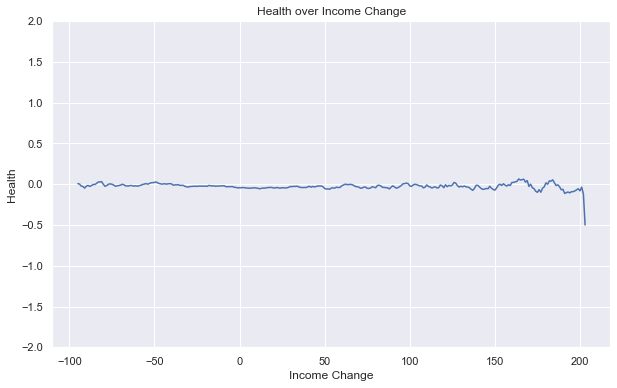

In [17]:
step = 10
groups_borders = [(x, x + 10) for x in range(-100, 200)]
x_values = [x + step / 2 for x, _ in groups_borders]
y_values = []

for left, right in groups_borders:
    y_values.append(tmp[(tmp['total_income_delta'] >= left) & (tmp['total_income_delta'] < right)]['rhltc'].mean())

plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values)
plt.title('Health over Income Change')
plt.xlabel('Income Change')
plt.ylabel('Health')

plt.ylim(-2, 2)

plt.show()

## Графики, связанные с браком

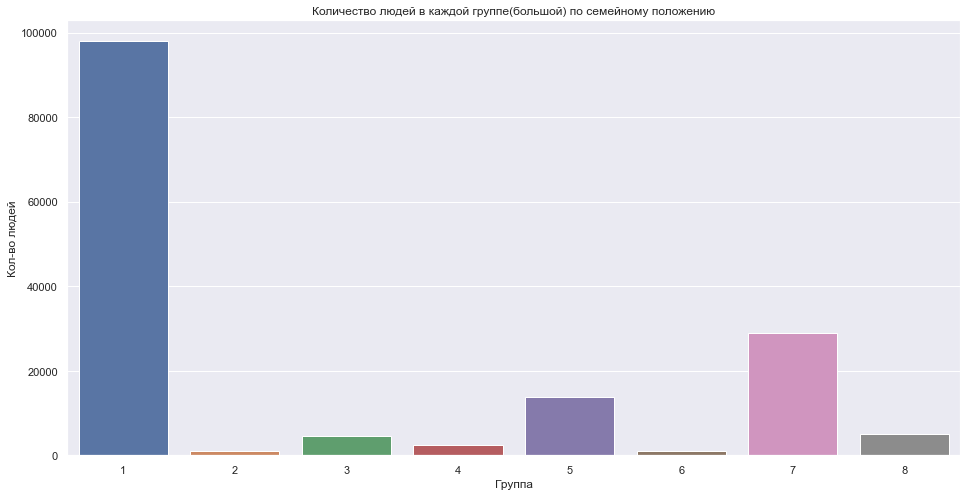

In [18]:
# plot amount of people in each rmstat group
plt.figure(figsize=(16, 8))

sns.countplot(x='rmstat', data=rmstat_df)
plt.title('Количество людей в каждой группе(большой) по семейному положению')
plt.xlabel('Группа')
plt.ylabel('Кол-во людей')

plt.show()

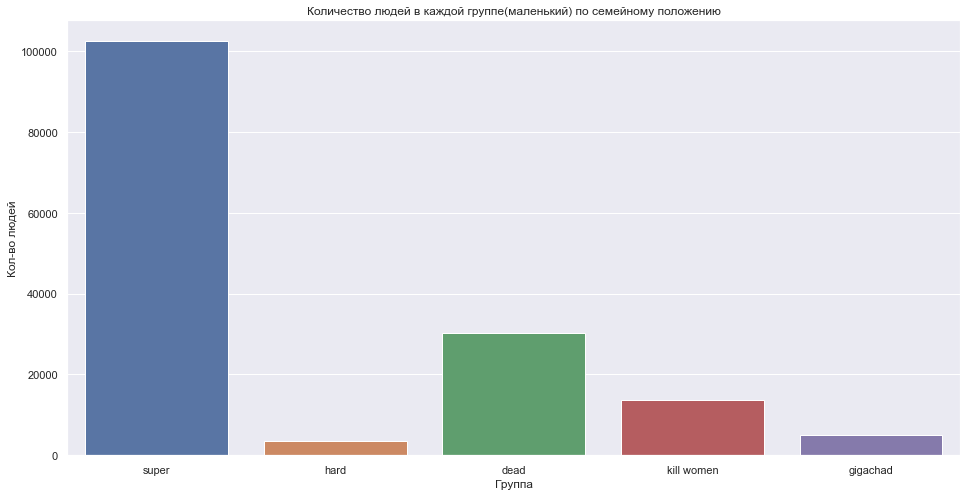

In [19]:
# plot amount of people in each mariage group
plt.figure(figsize=(16, 8))
sns.countplot(x='mariage_group', data=rmstat_df)
plt.title('Количество людей в каждой группе(маленький) по семейному положению')
plt.xlabel('Группа')
plt.ylabel('Кол-во людей')

plt.show()

In [20]:
all_mean_rhltc = rmstat_df['rhltc'].mean()
all_mean_rhltc

-0.14232650081718873

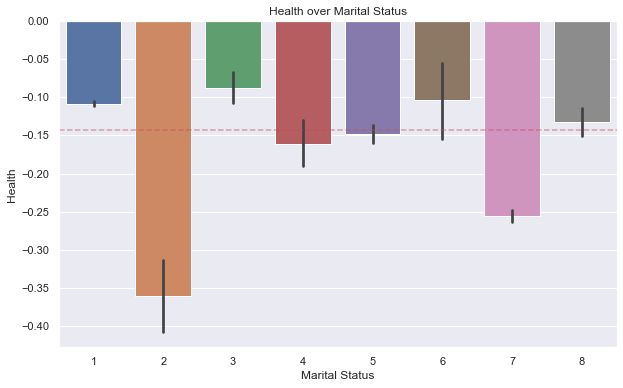

In [21]:
# plot mean rhltc by rmstat
plt.figure(figsize=(10, 6))
sns.barplot(x='rmstat', y='rhltc', data=rmstat_df)
plt.title('Health over Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Health')

plt.axhline(all_mean_rhltc, color='r', linestyle='--', alpha=0.5)

plt.show()

# Попытка в статанализ

## Связь между браком и здоровьем

In [14]:
rhltc_rmstat_pivot = single.groupby(['rmstat', 'rhltc'])['rhltc'].count().unstack('rhltc')
rhltc_rmstat_pivot = rhltc_rmstat_pivot.fillna(0)
rhltc_rmstat_pivot

rhltc,-2,-1,0,1,2
rmstat,,,,,
1,1362.0,14766.0,53303.0,6382.0,1537.0
2,12.0,28.0,44.0,17.0,0.0
3,21.0,356.0,1274.0,197.0,19.0
4,11.0,140.0,322.0,66.0,6.0
5,119.0,1154.0,2653.0,571.0,69.0
6,0.0,3.0,0.0,3.0,0.0
7,815.0,4429.0,8633.0,978.0,281.0
8,93.0,916.0,2668.0,410.0,63.0


In [23]:
chi2_contingency(rhltc_rmstat_pivot)

(2018.8390402349528,
 0.0,
 28,
 array([[1.81441126e+03, 1.62513975e+04, 5.13799804e+04, 6.43135334e+03,
         1.47285747e+03],
        [2.36917307e+00, 2.12203122e+01, 6.70895672e+01, 8.39775937e+00,
         1.92318817e+00],
        [4.37945161e+01, 3.92260622e+02, 1.24016061e+03, 1.55233829e+02,
         3.55504189e+01],
        [1.27841517e+01, 1.14505645e+02, 3.62017962e+02, 4.53146422e+01,
         1.03775995e+01],
        [1.07105388e+02, 9.59326192e+02, 3.03297984e+03, 3.79645241e+02,
         8.69433384e+01],
        [1.40742955e-01, 1.26061260e+00, 3.98551884e+00, 4.98876794e-01,
         1.14248802e-01],
        [3.55047560e+02, 3.18010540e+03, 1.00541355e+04, 1.25849986e+03,
         2.88211645e+02],
        [9.73472103e+01, 8.71923718e+02, 2.75665053e+03, 3.45056450e+02,
         7.90220881e+01]]))

In [24]:
rhltc_rmstat_pivot = rmstat_df.groupby(['mariage_group', 'rhltc'])['rhltc'].count().unstack('rhltc').reindex(['super', 'hard', 'dead', 'gigachad', 'kill women'])
# rhltc_rmstat_pivot = rhltc_rmstat_pivot.fillna(0)
rhltc_rmstat_pivot

rhltc,-2,-1,0,1,2
mariage_group,,,,,
super,1984,19721,70213,8399,2147
hard,146,783,2094,354,110
dead,1112,8696,17730,2169,451
gigachad,115,1098,3199,496,85
kill women,386,3290,8284,1436,301


In [25]:
chi2_contingency(rhltc_rmstat_pivot)

(2026.5516661029203,
 0.0,
 16,
 array([[ 2477.55316249, 22232.44873675, 67197.75502426,  8508.27367102,
          2047.96940549],
        [   84.31476302,   756.60279459,  2286.83802867,   289.54901517,
            69.69539855],
        [  729.21268225,  6543.62692265, 19778.16497523,  2504.22116422,
           602.77425565],
        [  120.72945562,  1083.37188225,  3274.50022287,   414.60230363,
            99.79613563],
        [  331.18993663,  2971.94966376,  8982.74174898,  1137.35384596,
           273.76480468]]))

## Исследование ПсиХОдУркИ

In [16]:
tmp_psycho = df[(df['rpsyche'] != '.m') & (df['rmstat'] != '.m')]
tmp_psycho['rpsyche'] = tmp_psycho['rpsyche'].astype(int)
tmp_psycho['rmstat'] = tmp_psycho['rmstat'].astype(int)

In [17]:
broken_df = tmp_psycho[tmp_psycho['broken'] == 1]

In [18]:
def get_broken_period(rows):
    indexes = rows.index
    # print(rows)

    statuses = rows['rmstat']
    pos = 0
    

    for i, st in enumerate(statuses):
        if i == 0:
            continue

        if st != 1:
            pos = i
            break
    # print(pos)

    return rows.iloc[pos-1:pos+1]

In [30]:
get_broken_period(broken_df[broken_df['hhidpn'] == 10645031])

,hhidpn,rmstat,ragender,rahispan,raracem,riwbegy,ragey_b,sagey_b,rhltc,rhlthlm,...,siearn_delta,ripena_delta,sipena_delta,rgov_delta,sgov_delta,total_work_income_delta,total_pension_income_delta,total_gov_income_delta,total_income_delta,broken
115611,10645031,1,2,0,2,2006-12-15,59,81,.m,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
120109,10645031,7,2,0,2,2008-04-15,61,.m,0,0,...,NaN,NaN,NaN,NaN,NaN,74.946601,NaN,NaN,-2.819784,1


In [19]:
def get_period_df(df):
    period_df = pd.DataFrame()


    for uid in broken_df['hhidpn'].unique():
        period_df = pd.concat([period_df, get_broken_period(df[df['hhidpn'] == uid])])

    return period_df

In [20]:
broken_period_df = get_period_df(broken_df)

In [21]:
broken_period_df['age_group'].unique()

array(['middle', 'old', 'young', 'dead outside'], dtype=object)

In [23]:
broken_period_young_df = broken_period_df[broken_period_df['age_group'] == 'young']
broken_period_middle_df = broken_period_df[broken_period_df['age_group'] == 'middle']
broken_period_old_df = broken_period_df[broken_period_df['age_group'] == 'old']
broken_period_dead_df = broken_period_df[broken_period_df['age_group'] == 'dead outside']

In [24]:
def drop_single(df):
    correct_indexes = (df['hhidpn'].value_counts() == 2).where(lambda x: x == True).dropna().index
    return df[df['hhidpn'].isin(correct_indexes)]

In [25]:
broken_period_young_df = drop_single(broken_period_young_df)
broken_period_young_df.shape

(568, 63)

In [26]:
broken_period_middle_df = drop_single(broken_period_middle_df)
broken_period_middle_df.shape

(4100, 63)

In [27]:
broken_period_old_df = drop_single(broken_period_old_df)
broken_period_old_df.shape

(2084, 63)

In [28]:
broken_period_dead_df = drop_single(broken_period_dead_df)
broken_period_dead_df.shape

(90, 63)

In [29]:
def get_pivot(df, column):
    pivot = df.groupby(['rmstat', column])[column].count().unstack(column)
    pivot.iloc[1, 0] = pivot.iloc[1:, 0].sum()
    pivot.iloc[1, 1] = pivot.iloc[1:, 1].sum()

    try:
        pivot.drop([5], axis=0, inplace=True)
    except KeyError:
        pass

    try:
        pivot.drop([7], axis=0, inplace=True)
    except KeyError:
        pass
    return pivot

In [172]:
def get_mcnemar_correlation(df, print=False):
    mcn = mcnemar(df, exact=False)
    correlation = np.sqrt(mcn.statistic / (mcn.statistic + df.sum().sum()))

    if print:
        return f'P-valueL {mcn.pvalue:.5f}, Statistic: {mcn.statistic:.3f}, Correlation: {correlation:.5f}'

    return np.round(mcn.pvalue, 5), np.round(mcn.statistic, 3), np.round(correlation, 5)

In [31]:
psycho_broken_pivot = get_pivot(broken_period_df, 'rpsyche')
psycho_broken_pivot

rpsyche,0,1
rmstat,,
1,2973,503
2,2783,693


In [106]:
psycho_broken_pivot.iloc[1, 0] = psycho_broken_pivot.iloc[1:, 0].sum()
psycho_broken_pivot.iloc[1, 1] = psycho_broken_pivot.iloc[1:, 1].sum()

psycho_broken_pivot.drop([5, 7], axis=0, inplace=True)
psycho_broken_pivot

rpsyche,0,1
rmstat,,
1,2973,503
2,2783,693


In [161]:
pivot_young = get_pivot(broken_period_young_df,'rpsyche')
pivot_young

rpsyche,0,1
rmstat,,
1,233,51
2,213,71


In [146]:
get_mcnemar_correlation(pivot_young, print=True)

'P-value: 0.00000, Statistic: 231.004, Correlation: 0.53769'

In [162]:
pivot_middle = get_pivot(broken_period_middle_df, 'rpsyche')
pivot_middle

rpsyche,0,1
rmstat,,
1,1764,286
2,1661,389


In [147]:
get_mcnemar_correlation(pivot_middle, print=True)

'P-value: 0.00000, Statistic: 1762.001, Correlation: 0.54825'

In [111]:
pivot_old = get_pivot(broken_period_old_df, 'rpsyche')
pivot_old

rpsyche,0,1
rmstat,,
1,894,148
2,830,212


In [148]:
get_mcnemar_correlation(pivot_old, print=True)

'P-value: 0.00000, Statistic: 892.001, Correlation: 0.54748'

In [114]:
pivot_dead = get_pivot(broken_period_dead_df, 'rpsyche')
pivot_dead

rpsyche,0,1
rmstat,,
1,37,8
2,36,9


In [149]:
get_mcnemar_correlation(pivot_dead, print=True)

'P-value: 0.00000, Statistic: 35.027, Correlation: 0.52930'

In [126]:
broken_df['ragender'].value_counts()

2    18999
1     7417
Name: ragender, dtype: int64

In [121]:
men_pivot = get_pivot(broken_period_df[broken_period_df['ragender'] == 1],'rpsyche')
men_pivot

rpsyche,0,1
rmstat,,
1,953,112
2,894,171


In [150]:
get_mcnemar_correlation(men_pivot, print=True)

'P-value: 0.00000, Statistic: 951.001, Correlation: 0.55558'

In [125]:
women_pivot = get_pivot(broken_period_df[broken_period_df['ragender'] == 2],'rpsyche')
women_pivot

rpsyche,0,1
rmstat,,
1,2020,391
2,1889,522


In [151]:
get_mcnemar_correlation(women_pivot, print=True)

'P-value: 0.00000, Statistic: 2018.000, Correlation: 0.54317'

In [240]:
print(mcnemar(psycho_broken_pivot, exact=False))

pvalue      3.994508795186043e-175
statistic   796.0012531328321


In [241]:
chi2_contingency(psycho_broken_pivot)

(6.401344834889139,
 0.011403395109763655,
 1,
 array([[777., 158.],
        [777., 158.]]))

In [186]:
def draw_lines(draw, pos):
    vert_step = 40
    hor_step = 75
    pos_x = 120
    pos_y = pos[1] + 120

    # горизонтальные линии
    draw.line(((80, pos_y), (270, pos_y)), (0, 0, 0))
    draw.line(((80, pos_y + vert_step), (270, pos_y + vert_step)), (0, 0, 0))
    draw.line(((80, pos_y + 2 * vert_step), (270, pos_y + 2 * vert_step)), (0, 0, 0))

    # вертикальные линии
    draw.line(((pos_x, pos[1] + 90), (pos_x, pos[1] + 200)), (0, 0, 0))
    draw.line(((pos_x + hor_step, pos[1] + 90), (pos_x + hor_step, pos[1] + 200)), (0, 0, 0))
    draw.line(((pos_x + 2 * hor_step, pos[1] + 90), (pos_x + 2 * hor_step, pos[1] + 200)), (0, 0, 0))


def get_pval_color(val):
    if val < 0.01:
        return (16, 235, 71)
    elif val < 0.05:
        return (245, 196, 20)
    else:
        return (255, 61, 61)

def get_correlation_color(val):
    if val >= 0.7:
        return (16, 235, 71)
    elif val >= 0.3:
        return (245, 196, 20)
    else:
        return (255, 61, 61)

In [203]:
def draw_pivot(pivot, stats, column, title, pos, img):
    draw = ImageDraw.Draw(img)
    font = ImageFont.truetype('arial.ttf', 20)
    hint_font = ImageFont.truetype('arial.ttf', 11)
    
    draw.text((pos[0] - 200, pos[1]), f'Возрастная группа {title}', (0, 0, 0), font=font, align='center')
    draw.text((130, pos[1] + 65), f'Наличие болезни {column}', (0, 0, 0), font=hint_font, align='center')

    # супруг
    draw.text((80, pos[1] + 130), f'Нет', (0, 0, 0), font=font, align='center')
    draw.text((80, pos[1] + 170), f'Да', (0, 0, 0), font=font, align='center')

    # болезнь
    draw.text((140, pos[1] + 90), f'Нет', (0, 0, 0), font=font, align='center')
    draw.text((220, pos[1] + 90), f'Да', (0, 0, 0), font=font, align='center')

    draw_lines(draw, pos)    

    # значения
    draw.text((140, pos[1] + 130), f'{pivot.iloc[0, 0]}', (0, 0, 0), font=font, align='center')
    draw.text((140, pos[1] + 170), f'{pivot.iloc[0, 1]}', (0, 0, 0), font=font, align='center')
    draw.text((220, pos[1] + 130), f'{pivot.iloc[1, 0]}', (0, 0, 0), font=font, align='center')
    draw.text((220, pos[1] + 170), f'{pivot.iloc[1, 1]}', (0, 0, 0), font=font, align='center')

    # статистики
    draw.text((pos[0] + 10, pos[1] + 85), f'Статистики', (0, 0, 0), font=font, align='center')

    draw.text((pos[0] + 10, pos[1] + 115), f'P-value:', (0, 0, 0), font=font, align='center')
    draw.text((pos[0] + 90, pos[1] + 115), f'{stats[0]}', get_pval_color(stats[0]), font=font, align='center')

    draw.text((pos[0] + 10, pos[1] + 145), f'Statistic:', (0, 0, 0), font=font, align='center')
    draw.text((pos[0] + 90, pos[1] + 145), f'{stats[1]}', (0, 0, 0), font=font, align='center')

    draw.text((pos[0] + 10, pos[1] + 175), f'Correlation:', (0, 0, 0), font=font, align='center')
    draw.text((pos[0] + 120, pos[1] + 175), f'{stats[2]}', get_correlation_color(stats[2]), font=font, align='center')

    status_text = Image.new('RGBA', (200, 200), (0, 0, 0, 0))
    dr = ImageDraw.Draw(status_text)
    dr.text((0, 0), f'Потерял супруга', fill=(0, 0, 0), font=hint_font, align='center')
    status_text = status_text.rotate(90, expand=1)

    img.paste(status_text, (40, pos[1] + 10), status_text)
    
    return img

In [206]:
def make_impressive_analysis(df, column):
    analysis_df = df[(df['rmstat'] != '.m') & (df[column] != '.m') & (df['broken'] == 1)]
    analysis_df['rmstat'] = analysis_df['rmstat'].astype(int)
    analysis_df[column] = analysis_df[column].astype(int)

    analysis_df = get_period_df(analysis_df)
    age_groups = ['young', 'middle', 'old', 'dead outside']

    img = Image.new('RGBA', (700, 1000), color=(255, 255, 255, 255))
    positions = [(400, 10), (390, 260), (410, 510), (370, 760)]

    for i, age_group in enumerate(age_groups):
        age_df = analysis_df[analysis_df['age_group'] == age_group]
        age_df = drop_single(age_df)

        pivot = get_pivot(age_df, column)
        stats = get_mcnemar_correlation(pivot)
        img = draw_pivot(pivot, stats, column, age_group, positions[i], img)

    for i, gender in enumerate(['Men', 'Women'], 1):
        pass
        # gender_df = analysis_df[analysis_df['ragender'] == i]

        # pivot = get_pivot(gender_df, column)
        # stats = get_mcnemar_correlation(pivot)

        # print(f'{gender} {column} {stats}')

    return img


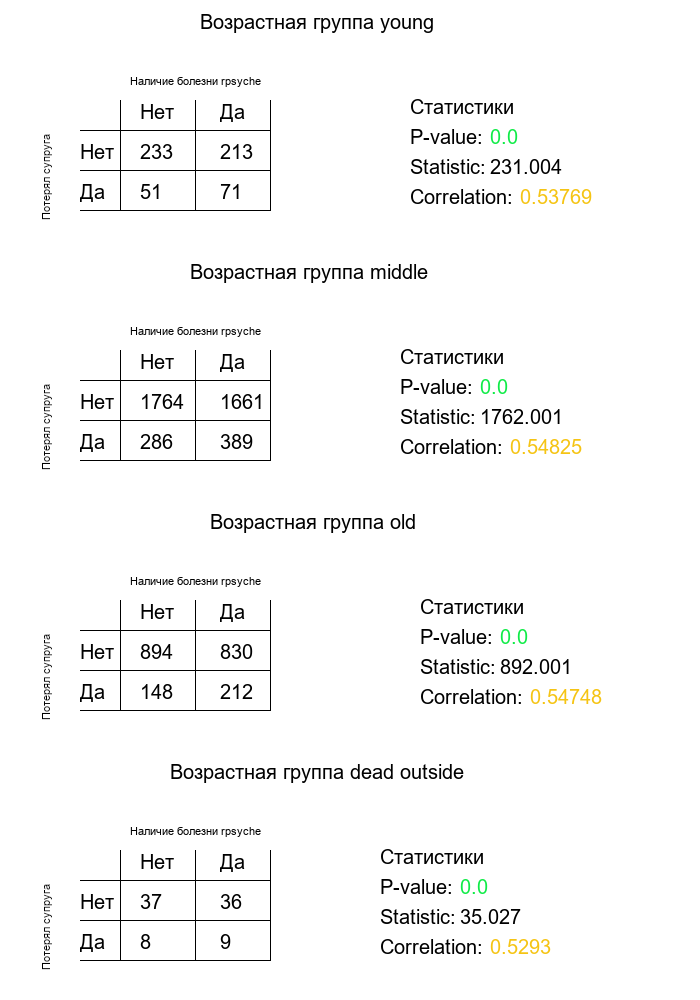

In [207]:
img = make_impressive_analysis(df, 'rpsyche')
display(img)

## Исследование сердца

In [166]:
heart_df = df[(df['rhearte'] != '.m') & (df['rmstat'] != '.m') & (df['broken'] == 1)]
heart_df['rhearte'] = heart_df['rhearte'].astype(int)
heart_df['rmstat'] = heart_df['rmstat'].astype(int)

In [182]:
heart_df = get_period_df(heart_df)

In [185]:
heart_young_df = heart_df[heart_df['age_group'] == 'young']
heart_middle_df = heart_df[heart_df['age_group'] == 'middle']
heart_old_df = heart_df[heart_df['age_group'] == 'old']
heart_dead_df = heart_df[heart_df['age_group'] == 'dead outside']

In [188]:
heart_young_df = drop_single(heart_young_df)
heart_middle_df = drop_single(heart_middle_df)
heart_old_df = drop_single(heart_old_df)
heart_dead_df = drop_single(heart_dead_df)

In [189]:
heart_young_pivot = get_pivot(heart_young_df, 'rhearte')
heart_young_pivot

rhearte,0,1
rmstat,,
1,253,31
2,248,36


In [193]:
get_mcnemar_correlation(heart_young_pivot)

'P-value: 0.00000, Statistic: 251.004, Correlation: 0.55360'

In [190]:
heart_middle_pivot = get_pivot(heart_middle_df, 'rhearte')
heart_middle_pivot

rhearte,0,1
rmstat,,
1,1656,394
2,1576,474


In [194]:
get_mcnemar_correlation(heart_middle_pivot)

'P-value: 0.00000, Statistic: 1654.001, Correlation: 0.53615'

In [191]:
heart_old_pivot = get_pivot(heart_old_df, 'rhearte')
heart_old_pivot

rhearte,0,1
rmstat,,
1,687,354
2,622,419


In [195]:
get_mcnemar_correlation(heart_old_pivot)

'P-value: 0.00000, Statistic: 685.001, Correlation: 0.49755'

In [192]:
heart_dead_pivot = get_pivot(heart_dead_df, 'rhearte')
heart_dead_pivot

rhearte,0,1
rmstat,,
1,29,16
2,24,21


In [196]:
get_mcnemar_correlation(heart_dead_pivot)

'P-value: 0.00000, Statistic: 27.034, Correlation: 0.48062'

In [201]:
men_pivot_heart = get_pivot(heart_df[heart_df['ragender'] == 1],'rhearte')
men_pivot_heart

rhearte,0,1
rmstat,,
1,720,348
2,653,415


In [202]:
get_mcnemar_correlation(men_pivot_heart)

'P-value: 0.00000, Statistic: 718.001, Correlation: 0.50157'

In [203]:
women_pivot_heart = get_pivot(heart_df[heart_df['ragender'] == 2],'rhearte')
women_pivot_heart

rhearte,0,1
rmstat,,
1,1943,464
2,1854,553


In [204]:
get_mcnemar_correlation(women_pivot_heart)

'P-value: 0.00000, Statistic: 1941.001, Correlation: 0.53604'

In [205]:
old_men_pivot_heart = get_pivot(heart_old_df[heart_old_df['ragender'] == 1],'rhearte')
old_men_pivot_heart

rhearte,0,1
rmstat,,
1,224,160
2,196,188


In [206]:
get_mcnemar_correlation(old_men_pivot_heart)

'P-value: 0.00000, Statistic: 222.004, Correlation: 0.47355'

In [207]:
old_women_pivot_heart = get_pivot(heart_old_df[heart_old_df['ragender'] == 2],'rhearte')
old_women_pivot_heart

rhearte,0,1
rmstat,,
1,463,194
2,426,231


In [208]:
get_mcnemar_correlation(old_women_pivot_heart)

'P-value: 0.00000, Statistic: 461.002, Correlation: 0.50963'

In [209]:
df[df['ragender'] == 1]['ragey_b'].mean()

65.48270982455658

In [210]:
df[df['ragender'] == 2]['ragey_b'].mean()

65.69195909118746

## И снова графики, но теперь по группам и возрастам

In [73]:
# rename ragender 1 for male, 2 for female
rmstat_df['ragender'].replace({1: 'male', 2: 'female'}, inplace=True)

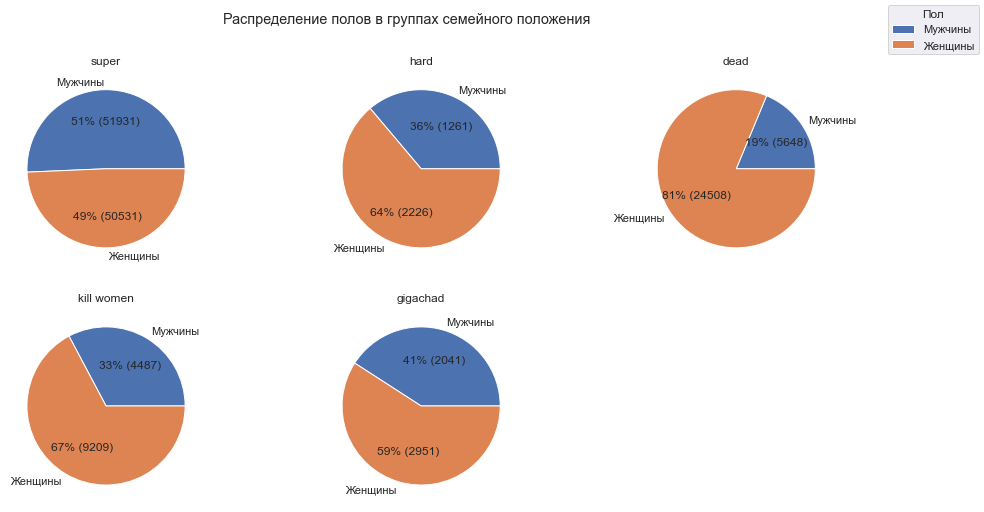

In [95]:
fig, ax = plt.subplots(2, 3, figsize=(16, 8))

for i, group in enumerate(rmstat_df['mariage_group'].unique()):
    row, col = i // 3, i % 3

    value_counts = rmstat_df[rmstat_df['mariage_group'] == group]['ragender'].value_counts().sort_index()

    ax[row, col].pie(value_counts, labels=['Мужчины', 'Женщины'], autopct=lambda x: f'{x:.0f}% ({int(x * value_counts.sum() / 100)})')
    ax[row, col].set_title(group)

ax[-1, -1].axis('off')
fig.legend(title='Пол', labels=['Мужчины', 'Женщины'])
fig.suptitle('Распределение полов в группах семейного положения')
plt.show()

In [156]:
def make_plotly_age_group_plot(group):
    age_groups = ['young', 'middle', 'old', 'dead outside']
    y_ticks = [-1, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2]

    tmp = rmstat_df[rmstat_df['mariage_group'] == group]
    mean_in_group = tmp['rhltc'].mean()

    fig = go.Figure()

    fig.add_trace(go.Bar(name='Мужчины',
        x=age_groups,
        y=tmp[tmp['ragender'] == 1].groupby('age_group')['rhltc'].mean().reindex(age_groups),
        marker_color='rgb(85, 177, 242)'
    ))

    fig.add_trace(go.Bar(name='Женщины',
        x=age_groups,
        y=tmp[tmp['ragender'] == 2].groupby('age_group')['rhltc'].mean().reindex(age_groups), 
        marker_color='rgb(242, 111, 85)'
    ))

    fig.update_layout(
        barmode='group',
        width=800, height=500,
        title=f'Среднее изменение здоровья по полу и группе возраста в группе брака {group}',
        xaxis_title='Группа возраста',
        yaxis_title='Среднее изменение здоровья',
        yaxis = dict(
            tickmode = 'array',
            tickvals = y_ticks,
            ticktext = y_ticks
        )
    )
    fig.update_yaxes(range=[-1, 0.2])

    fig.add_hline(
        y=mean_in_group,
        line_dash='dash',
        line_color='black',
        line_width=1,
        annotation_text=f'Среднее по группе: {mean_in_group:.2f}',
        annotation_position='bottom left'
    )

    fig.show()

In [157]:
make_plotly_age_group_plot('super')

In [158]:
make_plotly_age_group_plot('hard')

In [159]:
make_plotly_age_group_plot('dead')

In [160]:
make_plotly_age_group_plot('gigachad')

In [161]:
make_plotly_age_group_plot('kill women')

## Некрасивые и/или нерабочие графики

In [87]:
def draw_health_by_group_plot(selector, title, order=['young', 'middle', 'old', 'dead outside'], gender_hue=False):
    tmp = rmstat_df[selector]
    all_mean = tmp['rhltc'].mean()

    plt.figure(figsize=(16, 8))

    if not gender_hue:
        sns.barplot(x='age_group', y='rhltc', data=tmp, order=order)
    else:
        sns.barplot(x='age_group', y='rhltc', data=tmp, order=order, hue='ragender')
        plt.legend(title='Пол', labels=['Мужчины', 'Женщины'])
        
    plt.title(title)
    plt.xlabel('Группа возраста')
    plt.ylabel('Среднее изменение здоровья')

    plt.axhline(all_mean, color='red', linestyle='--', alpha=.5)

    plt.show()

In [ ]:
plt.figure(figsize=(16, 8))

sns.barplot(x='age_group', y='rhltc', data=rmstat_df, order=['young', 'middle', 'old', 'dead outside'], hue='ragender')

plt.legend(title='Пол', labels=['Мужчины', 'Женщины'])

plt.show()

In [ ]:
selector = (rmstat_df['mariage_group'] == 'super') & (rmstat_df['age_group'] != 'dead outside')
draw_health_by_group_plot(selector, 'Люди, у которых в жизни всё хорошо(super)', order=['young', 'middle', 'old'], gender_hue=True)

In [ ]:
selector = (rmstat_df['mariage_group'] == 'hard')
draw_health_by_group_plot(selector, 'Люди, у которых в жизни всё сложно(hard)', gender_hue=True, order=['young', 'middle', 'old'])

In [ ]:
selector = (rmstat_df['mariage_group'] == 'dead')
draw_health_by_group_plot(selector, 'Люди, у которых в жизни всё очень плохо(dead)', gender_hue=True)

In [ ]:
selector = (rmstat_df['mariage_group'] == 'gigachad')
draw_health_by_group_plot(selector, 'Люди, которые в жизни женщин не трогали(gigachad)', gender_hue=True, order=['young', 'middle', 'old'])

In [ ]:
selector = (rmstat_df['mariage_group'] == 'kill women')
draw_health_by_group_plot(selector, 'Группу не помню, но это kill women', gender_hue=True, order=['young', 'middle', 'old'])

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x='age_group', y='rhltc', data=rmstat_df, hue='ragender', order=['young', 'middle', 'old', 'dead outside'])
plt.title('Health over Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Health')

# horizontal line for all_mean_rhltc
plt.axhline(all_mean_rhltc, color='red', linestyle='--', alpha=.5)

plt.show()

# Подвал 

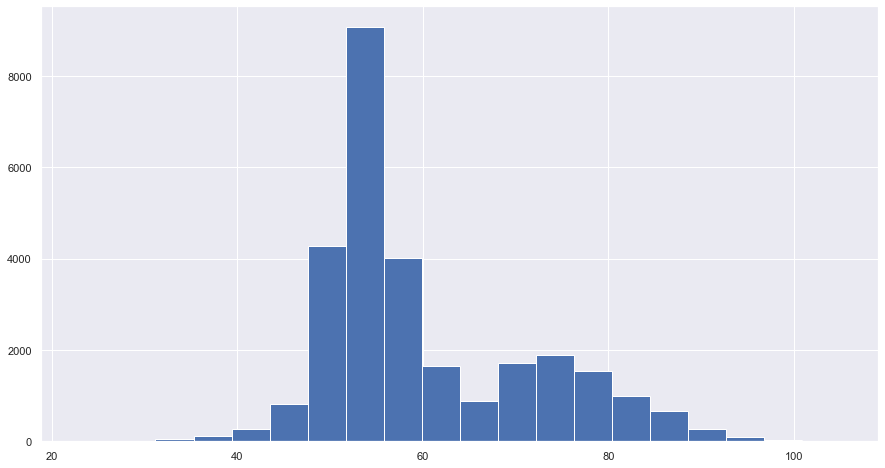

In [11]:
# histogram of ragey_b of index_wave = 1
sns.set()

plt.figure(figsize=(15, 8))
df[df['index_wave'] == 1]['ragey_b'].hist(bins=20)
plt.show()

In [13]:
df[(df['index_wave'] == 1) & (df['ragey_b'] > 50)].shape

(25148, 49)

In [14]:
df[(df['index_wave'] == 1) & (df['ragey_b'] <= 50)].shape

(3159, 49)

In [17]:
df[(df['index_wave'] == 1) & (df['riearn'] == 0)].shape

(12825, 49)

In [21]:
tmp = df[(df['index_wave'] == 1) & (df['ragey_b'] > 65)]

tmp[tmp['riearn'] == 0].shape[0] / tmp.shape[0] * 100

89.73048920679526

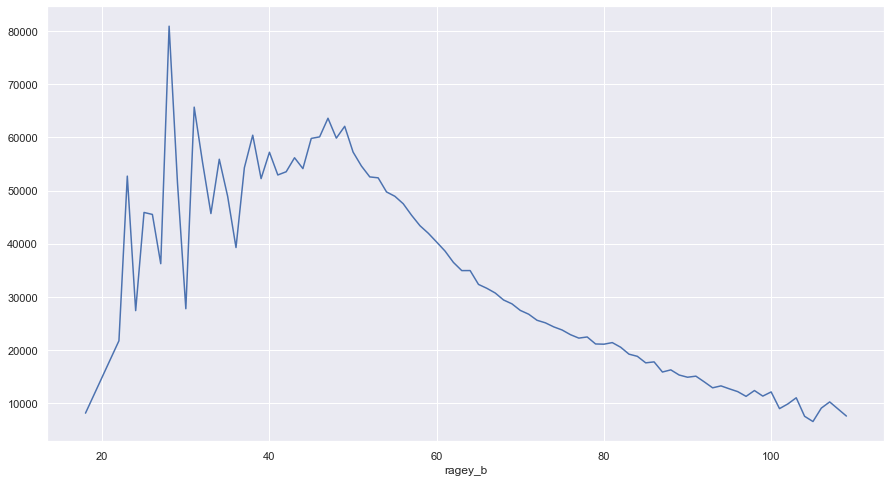

In [26]:
# plot median total_income by ragey_b in index_wave 1
plt.figure(figsize=(15, 8))
df[(df['total_income'] > 0)].groupby('ragey_b')['total_income'].median().plot()
plt.show()

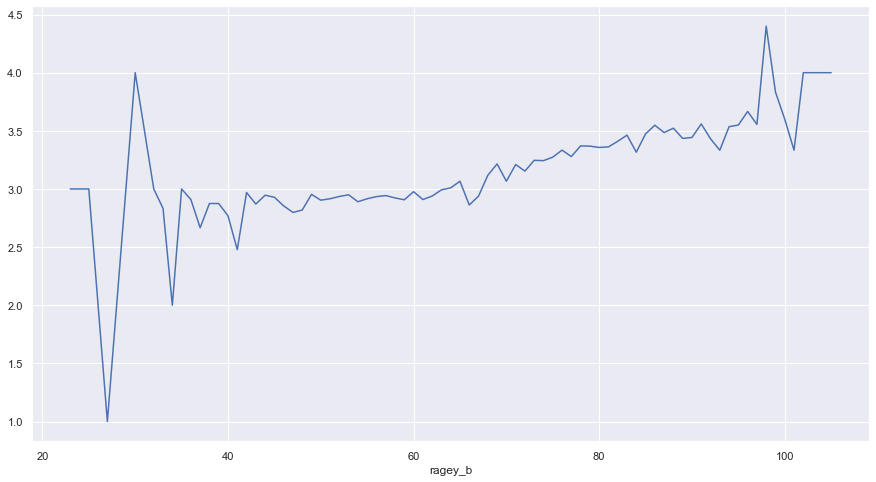

In [33]:
# plot the mean of rhltc by ragey_b
plt.figure(figsize=(15, 8))
tmp = df[(df['index_wave'] == 1) & (df['rhltc'] != '.m')]
tmp['rhltc'] = tmp['rhltc'].astype('int')
tmp.groupby('ragey_b')['rhltc'].mean().plot()
plt.show()

In [34]:
# percent of people with insured_gov
df[(df['insured_gov'] == 1)].shape[0] / df.shape[0] * 100

53.90575131323897

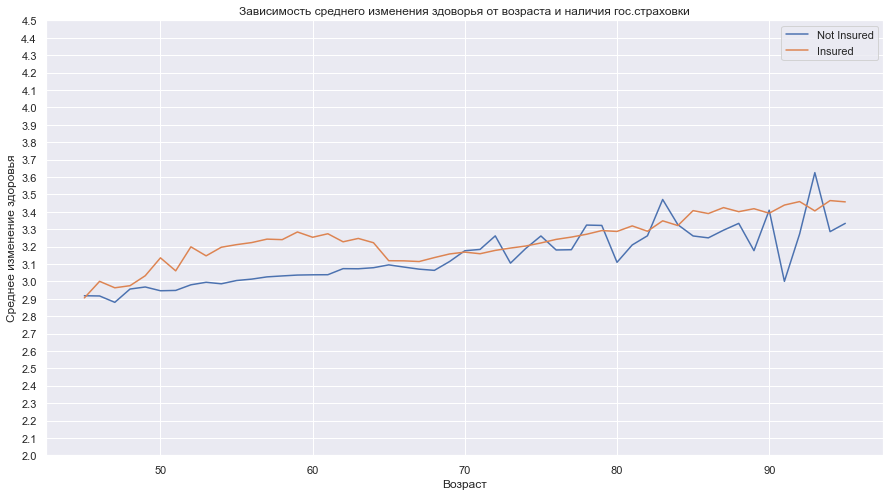

In [48]:
# line plot of mean of rhltc by ragey_b hue by insured_gov sns
plt.figure(figsize=(15, 8))
tmp = df[(df['rhltc'] != '.m') & (df['ragey_b'] >= 45) & (df['ragey_b'] <= 95)]
tmp['rhltc'] = tmp['rhltc'].astype('int')

sns.lineplot(x='ragey_b', y='rhltc', hue='insured_gov', data=tmp, ci=None)

plt.legend(['Not Insured', 'Insured'])
plt.yticks(np.arange(2, 4.6, 0.1))

plt.title('Зависимость среднего изменения здоворья от возраста и наличия гос.страховки')
plt.xlabel('Возраст')
plt.ylabel('Среднее изменение здоровья')

plt.show()